# Dataset Exploration -  N-CMAPSS DS02

The new C-MAPSS dataset DS02 from NASA provides degradation trajectories of 9 turbofan engines with unknown and different initial health condition for complete flights and two failure modes (HPT efficiency degradation & HPT efficiency degradation combined with LPT efficiency and capacity degradation). The data were synthetically generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model. The data contains multivariate sensors readings of the complete run-to-failure trajectories. Therefore, the records stop at the cycle/time the engine failed. A total number of 6.5M time stamps are available.

# Importing Libraries and Setting Paths

In [ ]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import pickle
from statsmodels.tsa.seasonal import STL
import json

In [ ]:
data_path = r"path_to/Data/N-CMAPSS_DS02-006.h5"
LSTM_AE_path = r"path_to/Models/best_model.h5"

# DATA

## Import Dataset

In [3]:
file= h5py.File(data_path, "r") # h5 file
print(list(file.keys()))
# Count rows
print("Count train:",len(file["A_dev"][:,1])) 
print("Count test:",len(file["A_test"][:,1]))
print("Count all:",len(file["A_dev"][:,1])+len(file["A_test"][:,1]))

['A_dev', 'A_test', 'A_var', 'T_dev', 'T_test', 'T_var', 'W_dev', 'W_test', 'W_var', 'X_s_dev', 'X_s_test', 'X_s_var', 'X_v_dev', 'X_v_test', 'X_v_var', 'Y_dev', 'Y_test']
Count train: 5263447
Count test: 1253743
Count all: 6517190


In [4]:
# Engines ID
print('Train units:',pd.DataFrame(file["A_dev"][:])[0].unique())
print('Test units:',pd.DataFrame(file["A_test"][:])[0].unique())

Train units: [ 2.  5. 10. 16. 18. 20.]
Test units: [11. 14. 15.]


In [5]:
# General data from pdf (Table 5)

M=1000000
# Available Dataset - 𝒟
df_available = pd.DataFrame({
    'Unit': [2, 5, 10, 16, 18, 20],
    'Flight class': [3,3,3,3,3,3],
    'm_i': [0.85*M, 1.03*M, 0.95*M, 0.77*M, 0.89*M, 0.77*M], # Row count
    't_s': [17, 17, 17, 16, 17, 17],   # Degeneration point
    't_EOL': [75, 89, 82, 63, 71, 66], # End Of Life
    'Failure Mode': ['HPT', 'HPT', 'HPT', 'HPT+LPT', 'HPT+LPT', 'HPT+LPT']
})

# Test Dataset - 𝒟_T*
df_test = pd.DataFrame({
    'Unit': [11, 14, 15],
    'Flight class': [3,1,2],
    'm_j': [0.66*M, 0.16*M, 0.43*M], # Row count
    't_s': [19, 36, 24],  # Degeneration point
    't_EOL': [59, 56, 67], # End Of Life
    'Failure Mode': ['HPT+LPT', 'HPT+LPT', 'HPT+LPT']
})

print("Train Dataset:")
print(df_available)
print("\nTest Dataset:")
print(df_test)


Train Dataset:
   Unit  Flight class        m_i  t_s  t_EOL Failure Mode
0     2             3   850000.0   17     75          HPT
1     5             3  1030000.0   17     89          HPT
2    10             3   950000.0   17     82          HPT
3    16             3   770000.0   16     63      HPT+LPT
4    18             3   890000.0   17     71      HPT+LPT
5    20             3   770000.0   17     66      HPT+LPT

Test Dataset:
   Unit  Flight class       m_j  t_s  t_EOL Failure Mode
0    11             3  660000.0   19     59      HPT+LPT
1    14             1  160000.0   36     56      HPT+LPT
2    15             2  430000.0   24     67      HPT+LPT


Flight Classes

The units are divided into three flight classes depending on whether the unit is operating short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights (i.e., flight class 2). 
A number of real flight conditions are available within each of the flight classes.

| Flight Class   | Flight Length [h]
| :-----------:  | :-----------:    
| 1              |    1 to 3        
| 2              |    3 to 5        
| 3              |    5 to 7        


_



| Unit           | Flight Class
| :-----------:  | :-----------:    
| 2              |    3        
| 5              |    3      
| 10             |    3      
| 11             |    3      
| 14             |    1      
| 15             |    2
| 16             |    3      
| 18             |    3      
| 20             |    3      


## Columns

### Features

In [6]:
# This function convert from h5 file to pd.DataFrame and adjust the columns
def add_cols (data,var):
    df= pd.DataFrame(data)
    cols=df.columns.tolist()
    for col_i in range(0,len(var)):
        df=df.rename(columns={cols[col_i]:var[col_i]})
    return df

In [7]:
# General data
"""
unit - Engine ID
cycle - Flight number
Fc - Flight class
hs - Health state (0/1)
"""
A_dev = file["A_dev"][:]
A_target = file["A_test"][:]  
A_var = file["A_var"][:]  
print(A_var)

A_train=add_cols(A_dev,A_var)
A_test=add_cols(A_target,A_var)

[b'unit' b'cycle' b'Fc' b'hs']


In [8]:
# Health Parameters
T_dev = file["T_dev"][:]
T_target = file["T_test"][:]  
T_var = file["T_var"][:]  
print(T_var)

T_train=add_cols(T_dev,T_var)
T_test=add_cols(T_target,T_var)

[b'fan_eff_mod' b'fan_flow_mod' b'LPC_eff_mod' b'LPC_flow_mod'
 b'HPC_eff_mod' b'HPC_flow_mod' b'HPT_eff_mod' b'HPT_flow_mod'
 b'LPT_eff_mod' b'LPT_flow_mod']


In [9]:
# Scenario descriptors
W_dev = file["W_dev"][:]
W_target = file["W_test"][:]  
W_var = file["W_var"][:]  
print(W_var)

W_train=add_cols(W_dev,W_var)
W_test=add_cols(W_target,W_var)

[b'alt' b'Mach' b'TRA' b'T2']


In [10]:
# Measurements
X_s_dev = file["X_s_dev"][:]
X_s_target = file["X_s_test"][:]  
X_s_var = file["X_s_var"][:]  
print(X_s_var)

X_s_train=add_cols(X_s_dev,X_s_var)
X_s_test=add_cols(X_s_target,X_s_var)

[b'T24' b'T30' b'T48' b'T50' b'P15' b'P2' b'P21' b'P24' b'Ps30' b'P40'
 b'P50' b'Nf' b'Nc' b'Wf']


In [11]:
# Virtual Sensors
X_v_dev = file["X_v_dev"][:]
X_v_target = file["X_v_test"][:]  
X_v_var = file["X_v_var"][:]  
print(X_v_var)

X_v_train=add_cols(X_v_dev,X_v_var)
X_v_test=add_cols(X_v_target,X_v_var)

[b'T40' b'P30' b'P45' b'W21' b'W22' b'W25' b'W31' b'W32' b'W48' b'W50'
 b'SmFan' b'SmLPC' b'SmHPC' b'phi']


In [12]:
del file

In [13]:
del A_dev, A_target, A_var
del T_dev, T_target, T_var
del W_dev, W_target, W_var
del X_s_dev, X_s_target, X_s_var
del X_v_dev, X_v_target, X_v_var

In [14]:
def move_column(df, col_name, new_idx):
    """
    Returns a new DataFrame where the column col_name is moved to position new_idx.
    The relative order of the other columns is preserved.
    """
    cols = list(df.columns)
    cols.insert(new_idx, cols.pop(cols.index(col_name)))
    return df[cols]


In [15]:
x_train = pd.concat([A_train, T_train, W_train, X_s_train, X_v_train], axis=1)
x_test = pd.concat([A_test, T_test, W_test, X_s_test, X_v_test], axis=1)

# Change column names to plain text
x_train.columns = [col.decode('utf-8') if isinstance(col,bytes) else col for col in x_train.columns]
x_test.columns = [col.decode('utf-8') if isinstance(col,bytes) else col for col in x_test.columns]

In [16]:
del A_train, T_train, W_train, X_s_train, X_v_train
del A_test, T_test, W_test, X_s_test, X_v_test

In [17]:
"""
# Export data to CSV files
x_train.to_csv('train_before_processing.csv', index=False)
x_test.to_csv('test_before_processing.csv', index=False)
"""

"\n# Export data to CSV files\nx_train.to_csv('train_before_processing.csv', index=False)\nx_test.to_csv('test_before_processing.csv', index=False)\n"

### Target

The Health State (`hs`) column indicates whether the sample is normal (1) or fault (0). 
The 'hs' column is not used as a label for model training.
It is included only for the purpose of data exploration and analysis.

In [18]:
"""
Health State:
0 - Fault
1 - Normal
"""

y_train = x_train['hs'].reset_index(drop=True)
y_test = x_test['hs'].reset_index(drop=True)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\ny_train value counts:")
print(y_train.value_counts())
print("\ny_test value counts:")
print(y_test.value_counts())

y_train shape: (5263447,)
y_test shape: (1253743,)

y_train value counts:
hs
0.0    4116722
1.0    1146725
Name: count, dtype: int64

y_test value counts:
hs
0.0    820630
1.0    433113
Name: count, dtype: int64


### Time

In [19]:
# Time by cycle
x_train['time_in_seconds'] = x_train.groupby(['unit', 'cycle']).cumcount()
x_test['time_in_seconds'] = x_test.groupby(['unit', 'cycle']).cumcount()

In [20]:
x_train = move_column(x_train, "time_in_seconds", 3)
x_test = move_column(x_test, "time_in_seconds", 3)
x_train.columns

Index(['unit', 'cycle', 'Fc', 'time_in_seconds', 'hs', 'fan_eff_mod',
       'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod',
       'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod',
       'LPT_flow_mod', 'alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50',
       'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf',
       'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50',
       'SmFan', 'SmLPC', 'SmHPC', 'phi'],
      dtype='object')

### Rolling Mean

In [21]:
"""
rolling mean columns for noise reduction – 
A moving average "smooths out" noise in sensor measurements, allowing the model to focus on the main trend of the degradation.
"""


sensor_features = ['T24', 'T30', 'T48', 'T50', 'P15', 'P24', 'Ps30', 'P40', 'P50', 'Nc', 'Nf', 'Wf',   # X_s
                   'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi'] # X_v
window_size = 10  # 10-second moving average




"""
This code calculates a rolling average separately for each engine (unit).
Using groupby(['unit', 'cycle']) ensures that the moving average is applied only within each engine's data, so trends are 
captured individually and not mixed between engines.
"""



for feature in sensor_features:
    x_train[feature] = (
        x_train
        .groupby(['unit', 'cycle'])[feature]
        .transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    )
    x_test[feature] = (
        x_test
        .groupby(['unit', 'cycle'])[feature]
        .transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    )

## Export Data

In [22]:
#x_train.describe().to_excel("x_train_describe.xlsx")
x_train.describe()

,unit,cycle,Fc,time_in_seconds,hs,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,...,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi
count,5.263447e+06,5.263447e+06,5263447.0,5.263447e+06,5.263447e+06,5263447.0,5263447.0,5263447.0,5263447.0,5263447.0,...,5.263447e+06,5.263447e+06,5.263447e+06,5.263447e+06,5.263447e+06,5.263447e+06,5.263447e+06,5.263447e+06,5.263447e+06,5.263447e+06
mean,1.140723e+01,3.795334e+01,3.0,6.238304e+03,2.178658e-01,0.0,0.0,0.0,0.0,0.0,...,1.521012e+02,1.521011e+02,1.747570e+01,1.048542e+01,1.420568e+02,1.504224e+02,1.928195e+01,8.164210e+00,2.789796e+01,3.862860e+01
std,6.630305e+00,2.237268e+01,0.0,3.930212e+03,4.127957e-01,0.0,0.0,0.0,0.0,0.0,...,2.771710e+01,2.771699e+01,3.274069e+00,1.964441e+00,2.673897e+01,2.826334e+01,1.506997e+00,9.381552e-01,2.032438e+00,2.241041e+00
min,2.000000e+00,1.000000e+00,3.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,7.013605e+01,7.013704e+01,7.793688e+00,4.676213e+00,6.302846e+01,6.688640e+01,1.448430e+01,3.725196e+00,2.386127e+01,2.860266e+01
25%,5.000000e+00,1.900000e+01,3.0,2.950000e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.322583e+02,1.322583e+02,1.513176e+01,9.079058e+00,1.229573e+02,1.302317e+02,1.816742e+01,7.699259e+00,2.641328e+01,3.767501e+01
50%,1.000000e+01,3.700000e+01,3.0,5.920000e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.457188e+02,1.457188e+02,1.672178e+01,1.003307e+01,1.358802e+02,1.438945e+02,1.897831e+01,8.315726e+00,2.747618e+01,3.900423e+01
75%,1.800000e+01,5.600000e+01,3.0,9.105000e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.694539e+02,1.694538e+02,1.952548e+01,1.171529e+01,1.587450e+02,1.680651e+02,1.995620e+01,8.856318e+00,2.873295e+01,4.012473e+01
max,2.000000e+01,8.900000e+01,3.0,1.816800e+04,1.000000e+00,0.0,0.0,0.0,0.0,0.0,...,2.502751e+02,2.502696e+02,2.907185e+01,1.744311e+01,2.370792e+02,2.508445e+02,2.724979e+01,1.094018e+01,3.879469e+01,4.386592e+01


In [23]:
#x_test.describe().to_excel("x_test_describe.xlsx")
x_test.describe()

,unit,cycle,Fc,time_in_seconds,hs,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,...,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi
count,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1253743.0,1253743.0,1253743.0,1253743.0,1253743.0,...,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06
mean,1.275811e+01,3.259971e+01,2.404163e+00,4.446968e+03,3.454560e-01,0.0,0.0,0.0,0.0,0.0,...,1.619486e+02,1.619485e+02,1.863892e+01,1.118335e+01,1.515160e+02,1.604233e+02,1.928324e+01,8.064686e+00,2.799269e+01,3.859286e+01
std,1.888477e+00,1.903162e+01,7.006509e-01,3.415406e+03,4.755169e-01,0.0,0.0,0.0,0.0,0.0,...,2.884603e+01,2.884582e+01,3.407412e+00,2.044447e+00,2.784096e+01,2.942743e+01,1.485094e+00,9.408115e-01,2.110659e+00,2.369915e+00
min,1.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,8.135360e+01,8.135608e+01,9.118937e+00,5.471362e+00,7.374619e+01,7.822102e+01,1.455566e+01,3.999138e+00,2.405422e+01,2.866073e+01
25%,1.100000e+01,1.600000e+01,2.000000e+00,1.572000e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.403478e+02,1.403479e+02,1.608734e+01,9.652406e+00,1.306353e+02,1.383566e+02,1.814338e+01,7.536853e+00,2.626689e+01,3.737704e+01
50%,1.100000e+01,3.200000e+01,3.000000e+00,3.776000e+03,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.558264e+02,1.558260e+02,1.791569e+01,1.074942e+01,1.456004e+02,1.541714e+02,1.922488e+01,8.188757e+00,2.771912e+01,3.886524e+01
75%,1.500000e+01,4.800000e+01,3.000000e+00,6.613000e+03,1.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.824240e+02,1.824244e+02,2.105763e+01,1.263458e+01,1.711954e+02,1.812299e+02,1.996799e+01,8.761218e+00,2.910320e+01,4.029766e+01
max,1.500000e+01,7.600000e+01,3.000000e+00,1.763500e+04,1.000000e+00,0.0,0.0,0.0,0.0,0.0,...,2.399814e+02,2.399787e+02,2.785623e+01,1.671374e+01,2.270081e+02,2.402067e+02,2.724712e+01,1.020983e+01,3.873122e+01,4.345340e+01


In [24]:
"""
# describe the engines

for name, df_to_describe in [('train', x_train), ('test', x_test)]:
    for engine in df_to_describe['unit'].unique():
        desc = df_to_describe[df_to_describe['unit'] == engine].describe()
        filename = f'{name}_describe_engine_{engine}.xlsx'
        desc.to_excel(filename, sheet_name='describe')
        print(f'Created {filename}')
"""

"\n# describe the engines\n\nfor name, df_to_describe in [('train', x_train), ('test', x_test)]:\n    for engine in df_to_describe['unit'].unique():\n        desc = df_to_describe[df_to_describe['unit'] == engine].describe()\n        filename = f'{name}_describe_engine_{engine}.xlsx'\n        desc.to_excel(filename, sheet_name='describe')\n        print(f'Created {filename}')\n"

In [25]:
"""
# Unique value information

df_unique = x_train # x_test
unique_info = []
for col in df_unique.columns:
    nunique = df_unique[col].nunique()
    if nunique > 100:
        unique_info.append({
            'Column': col,
            'Unique_Count': nunique,
            'Unique_Values': 'Too many to display (>100)'
        })
    else:
        unique_values = df_unique[col].unique()
        unique_info.append({
            'Column': col,
            'Unique_Count': nunique,
            'Unique_Values': str(unique_values.tolist())
        })

# Convert to DataFrame and save to Excel
unique_df = pd.DataFrame(unique_info)
unique_df.to_excel('x_train_unique_values.xlsx', index=False)
#unique_df.to_excel('x_test_unique_values.xlsx', index=False)
"""

"\n# Unique value information\n\ndf_unique = x_train # x_test\nunique_info = []\nfor col in df_unique.columns:\n    nunique = df_unique[col].nunique()\n    if nunique > 100:\n        unique_info.append({\n            'Column': col,\n            'Unique_Count': nunique,\n            'Unique_Values': 'Too many to display (>100)'\n        })\n    else:\n        unique_values = df_unique[col].unique()\n        unique_info.append({\n            'Column': col,\n            'Unique_Count': nunique,\n            'Unique_Values': str(unique_values.tolist())\n        })\n\n# Convert to DataFrame and save to Excel\nunique_df = pd.DataFrame(unique_info)\nunique_df.to_excel('x_train_unique_values.xlsx', index=False)\n#unique_df.to_excel('x_test_unique_values.xlsx', index=False)\n"

In [26]:
"""
# export data (first 100k rows)

train= pd.concat([y_train,x_train], axis=1)
test= pd.concat([y_test,x_test], axis=1)
train.head(100000).to_csv("train.csv")
test.head(100000).to_csv("test.csv")
"""

'\n# export data (first 100k rows)\n\ntrain= pd.concat([y_train,x_train], axis=1)\ntest= pd.concat([y_test,x_test], axis=1)\ntrain.head(100000).to_csv("train.csv")\ntest.head(100000).to_csv("test.csv")\n'

In [27]:
#raise ExceptionType("stop")

## Data Analysis Overview

### Stationarity


In [28]:
# stationarity check by engine

feature = 'T48'
n_periods = 10

example_unit = 20
series = x_train[(x_train['unit'] == example_unit)][feature].reset_index(drop=True)

Stationarity check for feature 'T48' (unit=20):
Segment 1: mean=1636.603, variance=7202.384
Segment 2: mean=1624.645, variance=12642.727
Segment 3: mean=1642.528, variance=8589.351
Segment 4: mean=1624.885, variance=11434.696
Segment 5: mean=1634.684, variance=10327.501
Segment 6: mean=1649.176, variance=9815.905
Segment 7: mean=1631.865, variance=9885.563
Segment 8: mean=1659.545, variance=6874.550
Segment 9: mean=1665.027, variance=9948.920
Segment 10: mean=1662.152, variance=10016.229


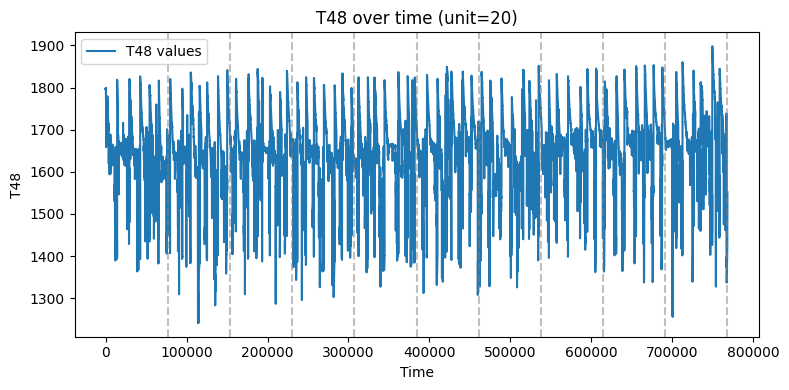

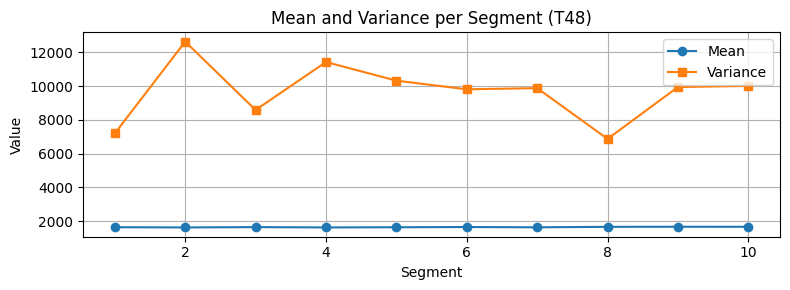

In [29]:
period_length = len(series) // n_periods
means = []
vars_ = []

for i in range(n_periods):
    start = i * period_length
    # The last segment continues to the end
    end = (i + 1) * period_length if i < n_periods - 1 else len(series)
    segment = series[start:end]
    means.append(segment.mean())
    vars_.append(segment.var())

# Display the means and variances for each segment
print(f"Stationarity check for feature '{feature}' (unit={example_unit}):")
for i, (mean, var) in enumerate(zip(means, vars_)):
    print(f"Segment {i+1}: mean={mean:.3f}, variance={var:.3f}")


plt.figure(figsize=(8, 4))
plt.plot(series.values, label=f'{feature} values')
for i in range(1, n_periods+1):
    plt.axvline(i * period_length, color='gray', linestyle='--', alpha=0.5)
plt.title(f"{feature} over time (unit={example_unit})")
plt.xlabel('Time')
plt.ylabel(feature)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(1, n_periods+1), means, marker='o', label='Mean')
plt.plot(range(1, n_periods+1), vars_, marker='s', label='Variance')
plt.title(f"Mean and Variance per Segment ({feature})")
plt.xlabel('Segment')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# stationarity check by engine and cycle

feature = 'T48'
n_periods = 10

example_unit = 20
example_cycle = 50
series = x_train[(x_train['unit'] == example_unit) & (x_train['cycle'] == example_cycle)][feature].reset_index(drop=True)

Stationarity check for feature 'T48' (unit=20, cycle=50):
Segment 1: mean=1795.598, variance=386.215
Segment 2: mean=1737.704, variance=139.448
Segment 3: mean=1696.549, variance=249.993
Segment 4: mean=1676.341, variance=40.749
Segment 5: mean=1675.143, variance=67.420
Segment 6: mean=1671.753, variance=326.423
Segment 7: mean=1663.634, variance=556.293
Segment 8: mean=1648.501, variance=3048.289
Segment 9: mean=1592.997, variance=2212.846
Segment 10: mean=1554.409, variance=2871.840


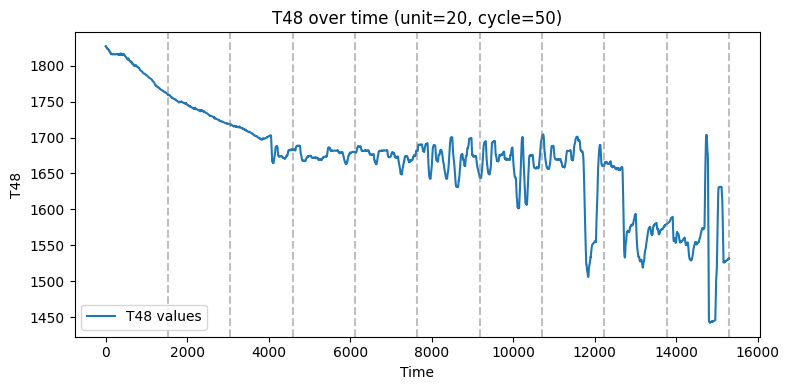

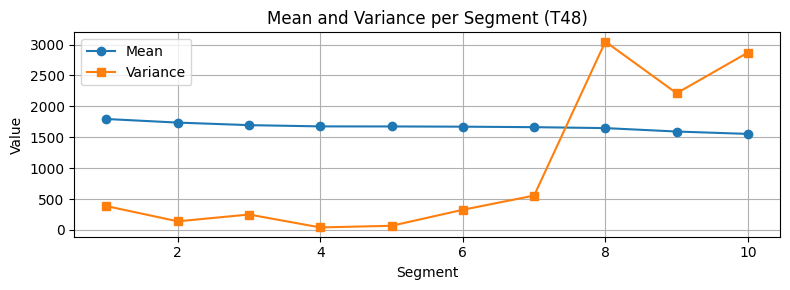

In [31]:
period_length = len(series) // n_periods
means = []
vars_ = []

for i in range(n_periods):
    start = i * period_length
    # The last segment continues to the end
    end = (i + 1) * period_length if i < n_periods - 1 else len(series)
    segment = series[start:end]
    means.append(segment.mean())
    vars_.append(segment.var())

# Display the means and variances for each segment
print(f"Stationarity check for feature '{feature}' (unit={example_unit}, cycle={example_cycle}):")
for i, (mean, var) in enumerate(zip(means, vars_)):
    print(f"Segment {i+1}: mean={mean:.3f}, variance={var:.3f}")


plt.figure(figsize=(8, 4))
plt.plot(series.values, label=f'{feature} values')
for i in range(1, n_periods+1):
    plt.axvline(i * period_length, color='gray', linestyle='--', alpha=0.5)
plt.title(f"{feature} over time (unit={example_unit}, cycle={example_cycle})")
plt.xlabel('Time')
plt.ylabel(feature)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(1, n_periods+1), means, marker='o', label='Mean')
plt.plot(range(1, n_periods+1), vars_, marker='s', label='Variance')
plt.title(f"Mean and Variance per Segment ({feature})")
plt.xlabel('Segment')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div dir="rtl">

מסקנות:
מהבדיקה עולה כי כל מנוע (unit) בפני עצמו מציג התנהגות סטציונרית לאורך זמן, כלומר הממוצע והשונות של התכונות עבור כל מנוע נשארים יציבים יחסית.
לעומת זאת, כאשר בוחנים כל טיסה (cycle) בנפרד, ניתן לראות שהתנהגות התכונות משתנה לאורך הטיסה – כלומר, כל טיסה אינה סטציונרית.
יש לקחת בחשבון את חוסר הסטציונריות של הטיסות בניתוחים עתידיים.

</div>

### Linearity

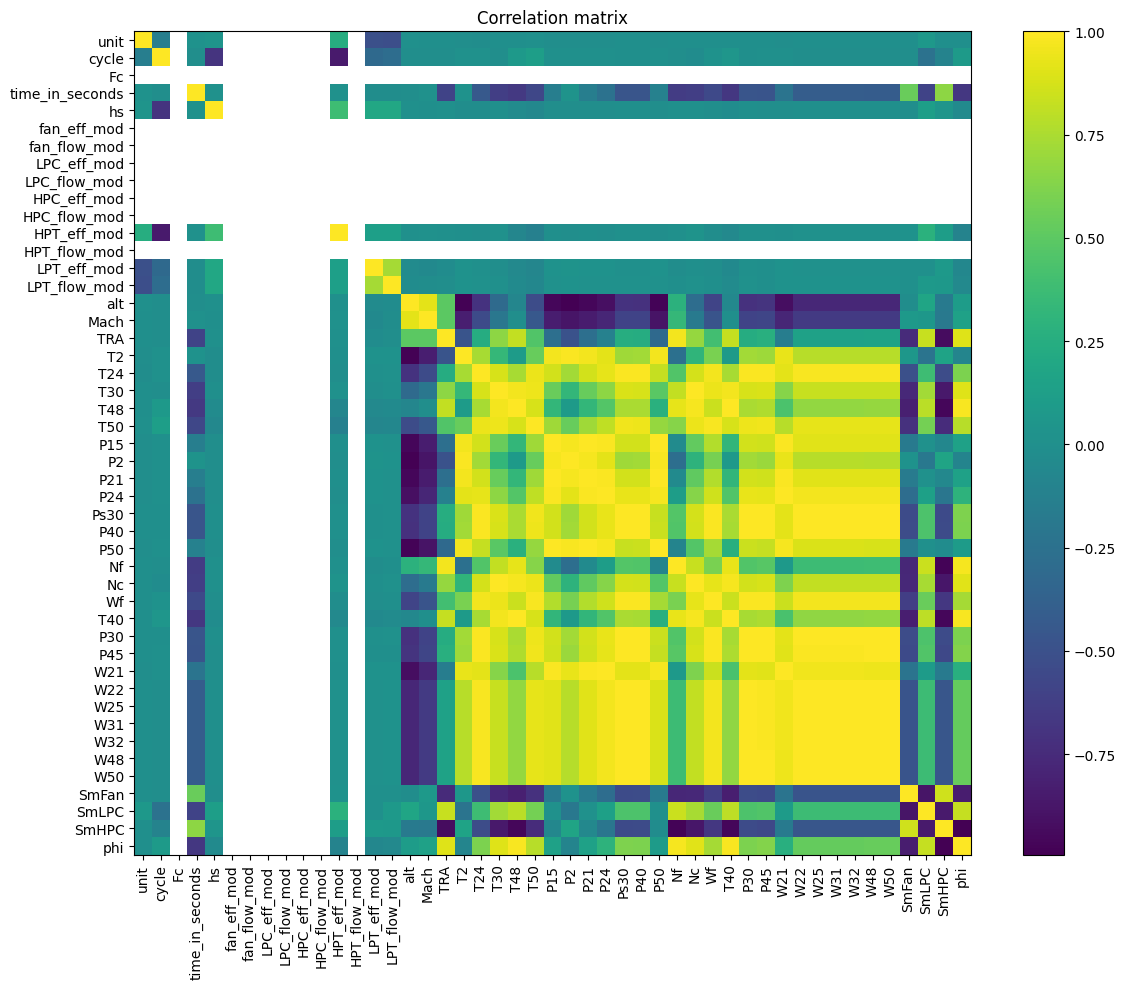

In [32]:
"""
Correlation matrix
It can be observed that all sensors have near-zero correlation, indicating a non-linear pattern.
"""

df_corr = x_train

corr_mat = df_corr.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_mat, aspect='auto')
plt.colorbar()
labels = corr_mat.columns.tolist()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

### Trend and Seasonality

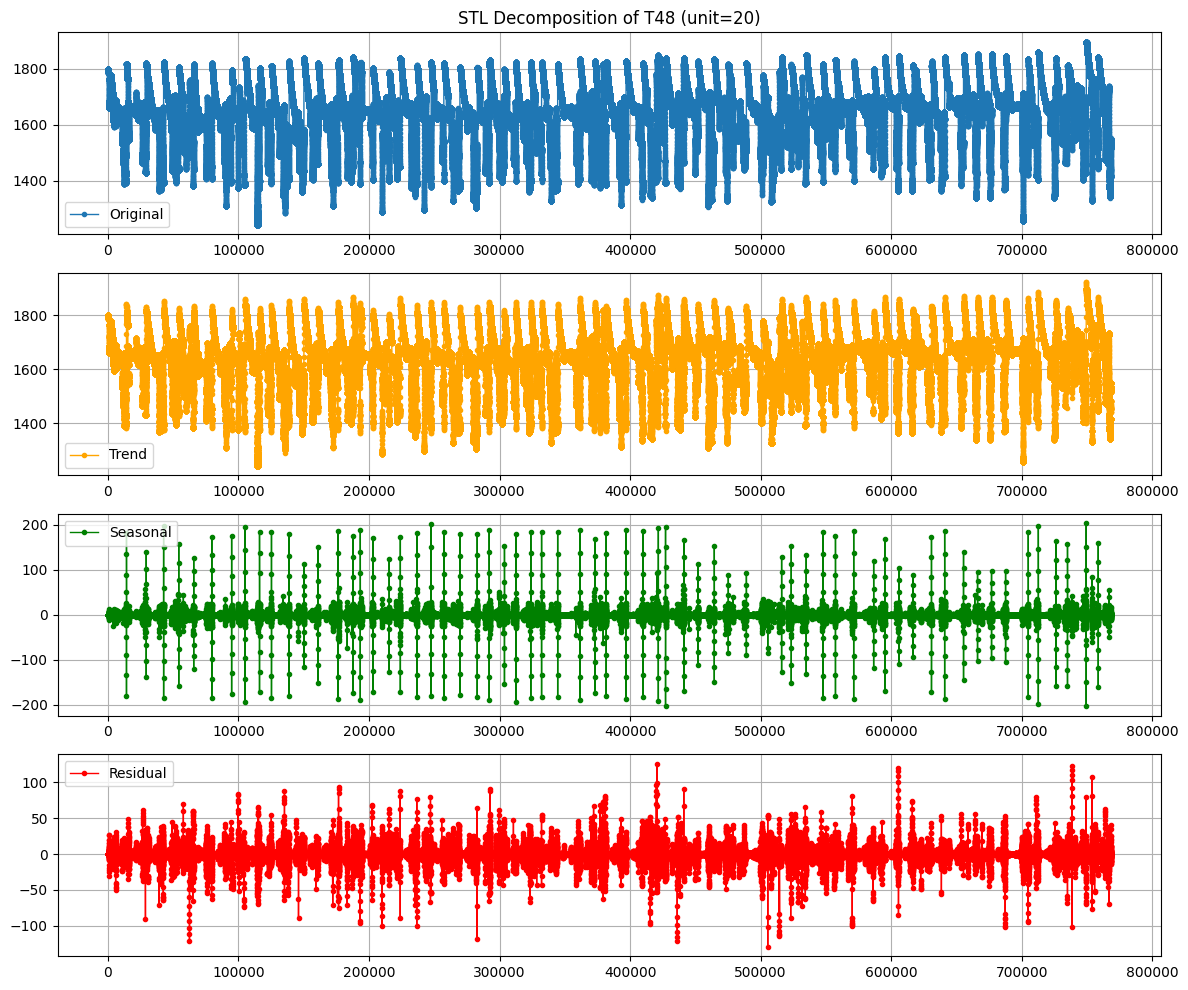

In [33]:
# STL Decomposition by unit

unit_id = 20
feature = 'T48'

demo = x_train[(x_train['unit'] == unit_id)].copy()
demo = demo.reset_index(drop=True)

stl = STL(demo[feature], period=10, robust=True)
res = stl.fit()

plt.figure(figsize=(12, 10))

# Original
plt.subplot(4, 1, 1)
plt.plot(demo.index, demo[feature], color='tab:blue', linewidth=1, marker='o', markersize=3, label='Original')
plt.title(f'STL Decomposition of {feature} (unit={unit_id})')
plt.legend()
plt.grid(True)

# Trend
plt.subplot(4, 1, 2)
plt.plot(demo.index, res.trend, color='orange', linewidth=1, marker='o', markersize=3, label='Trend')
plt.legend()
plt.grid(True)

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(demo.index, res.seasonal, color='green', linewidth=1, marker='o', markersize=3, label='Seasonal')
plt.legend()
plt.grid(True)

# Residual
plt.subplot(4, 1, 4)
plt.plot(demo.index, res.resid, color='red', linewidth=1, marker='o', markersize=3, label='Residual')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

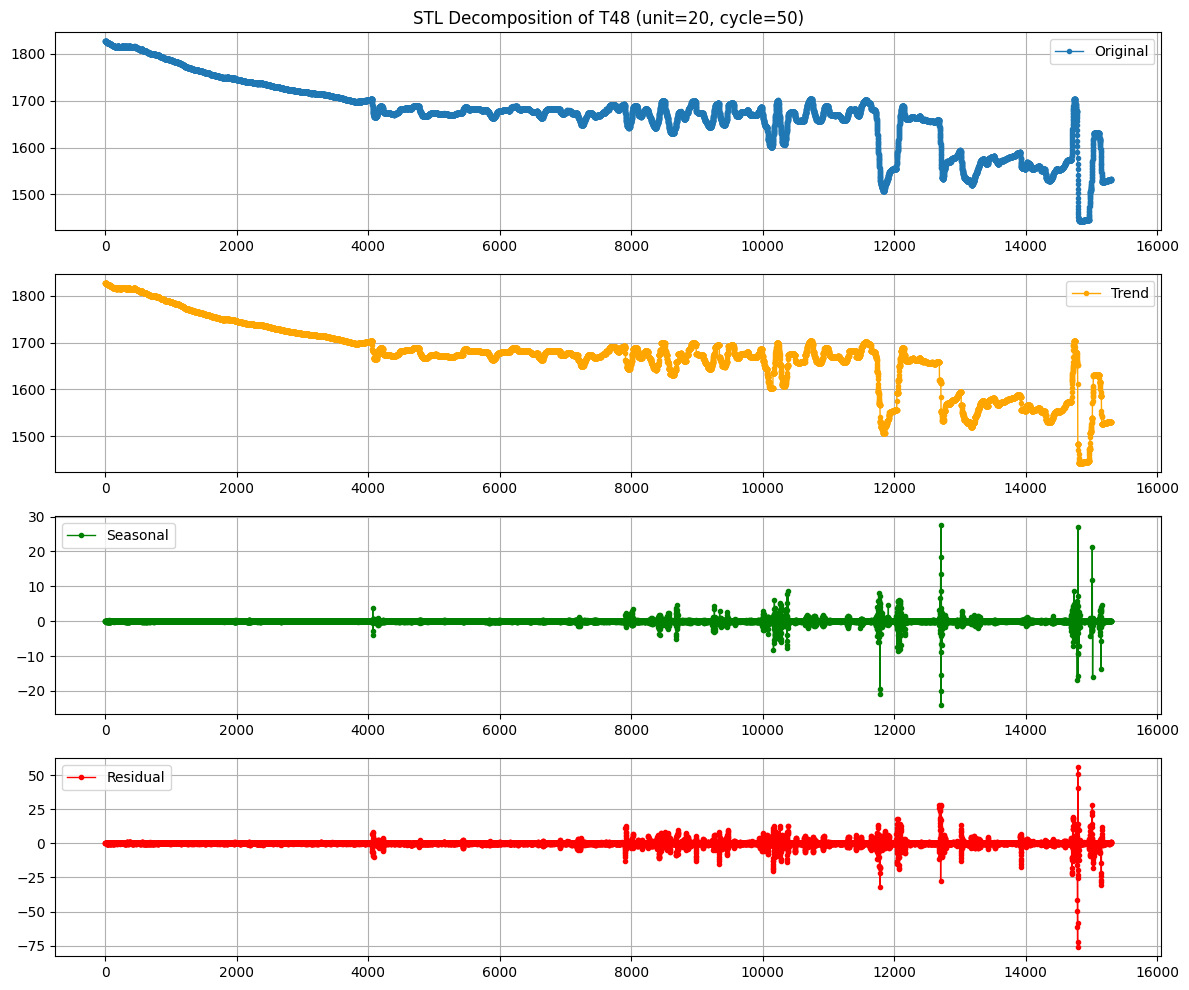

In [34]:
# STL Decomposition by unit and cycle

unit_id = 20
cycle_id = 50
feature = 'T48'

demo = x_train[(x_train['unit'] == unit_id ) & (x_train['cycle'] == cycle_id)].copy()
demo = demo.reset_index(drop=True)

stl = STL(demo[feature], period=10, robust=True)
res = stl.fit()

plt.figure(figsize=(12, 10))

# Original
plt.subplot(4, 1, 1)
plt.plot(demo.index, demo[feature], color='tab:blue', linewidth=1, marker='o', markersize=3, label='Original')
plt.title(f'STL Decomposition of {feature} (unit={unit_id}, cycle={cycle_id})')
plt.legend()
plt.grid(True)

# Trend
plt.subplot(4, 1, 2)
plt.plot(demo.index, res.trend, color='orange', linewidth=1, marker='o', markersize=3, label='Trend')
plt.legend()
plt.grid(True)

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(demo.index, res.seasonal, color='green', linewidth=1, marker='o', markersize=3, label='Seasonal')
plt.legend()
plt.grid(True)

# Residual
plt.subplot(4, 1, 4)
plt.plot(demo.index, res.resid, color='red', linewidth=1, marker='o', markersize=3, label='Residual')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Downsample

Downdampling the data to minutes

In [ ]:

sensor_features = ['T24', 'T30', 'T48', 'T50', 'P15', 'P24', 'Ps30', 'P40', 'P50', 'Nc', 'Nf', 'Wf',   # X_s
                   'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi'] #X_v

seconds = 60

x_train['time_bin'] = x_train.groupby(['unit', 'cycle'])['time_in_seconds'].transform(lambda x: (x // seconds).astype(int) + 1)
x_test['time_bin'] = x_test.groupby(['unit', 'cycle'])['time_in_seconds'].transform(lambda x: (x // seconds).astype(int) + 1)
x_train = move_column(x_train, "time_bin", 3)
x_test = move_column(x_test, "time_bin", 3)
print(x_train.iloc[seconds*11:seconds*11+30, :5]) # Example


     unit  cycle   Fc  time_bin  time_in_seconds
660   2.0    1.0  3.0        12              660
661   2.0    1.0  3.0        12              661
662   2.0    1.0  3.0        12              662
663   2.0    1.0  3.0        12              663
664   2.0    1.0  3.0        12              664
665   2.0    1.0  3.0        12              665
666   2.0    1.0  3.0        12              666
667   2.0    1.0  3.0        12              667
668   2.0    1.0  3.0        12              668
669   2.0    1.0  3.0        12              669
670   2.0    1.0  3.0        12              670
671   2.0    1.0  3.0        12              671
672   2.0    1.0  3.0        12              672
673   2.0    1.0  3.0        12              673
674   2.0    1.0  3.0        12              674
675   2.0    1.0  3.0        12              675
676   2.0    1.0  3.0        12              676
677   2.0    1.0  3.0        12              677
678   2.0    1.0  3.0        12              678
679   2.0    1.0  3.

In [36]:
# train
downsampled_train_data = []

for (unit, cycle, time_bin), group in x_train.groupby(['unit', 'cycle', 'time_bin']):

    sensor_means = group[sensor_features].mean()
    
    non_sensor_cols = [col for col in x_train.columns if col not in sensor_features + ['time_in_seconds', 'time_bin']]
    non_sensor_values = group[non_sensor_cols].iloc[-1]
    
    row = pd.concat([non_sensor_values, sensor_means])
    row['time_in_seconds'] = (time_bin - 1) * seconds
    downsampled_train_data.append(row)

x_train_downsampled = pd.DataFrame(downsampled_train_data)


In [37]:
# test
downsampled_test_data = []

for (unit, cycle, time_bin), group in x_test.groupby(['unit', 'cycle', 'time_bin']):

    sensor_means = group[sensor_features].mean()
    
    non_sensor_cols = [col for col in x_test.columns if col not in sensor_features + ['time_in_seconds', 'time_bin']]
    non_sensor_values = group[non_sensor_cols].iloc[-1]
    
    row = pd.concat([non_sensor_values, sensor_means])
    row['time_in_seconds'] = (time_bin - 1) * seconds
    downsampled_test_data.append(row)

x_test_downsampled = pd.DataFrame(downsampled_test_data)


In [38]:
original_cols = [col for col in x_train.columns if col != 'time_bin']
x_train_downsampled = x_train_downsampled[original_cols]
x_test_downsampled = x_test_downsampled[original_cols]

print(f"Original train shape: {x_train.shape}")
print(f"Downsampled train shape: {x_train_downsampled.shape}")
print(f"Train downsampling factor: {len(x_train) / len(x_train_downsampled):.1f}x")

print(f"/nOriginal test shape: {x_test.shape}")
print(f"Downsampled test shape: {x_test_downsampled.shape}")
print(f"Test downsampling factor: {len(x_test) / len(x_test_downsampled):.1f}x")


Original train shape: (5263447, 48)
Downsampled train shape: (87949, 47)
Train downsampling factor: 59.8x
/nOriginal test shape: (1253743, 48)
Downsampled test shape: (20995, 47)
Test downsampling factor: 59.7x


In [39]:
# y train
x_train_copy = x_train.copy()
x_train_copy['time_bin'] = x_train_copy.groupby(['unit', 'cycle'])['time_in_seconds'].transform(lambda x: (x // seconds).astype(int) + 1)

downsampled_train_targets = []

for (unit, cycle, time_bin), group in x_train_copy.groupby(['unit', 'cycle', 'time_bin']):
    last_idx = group.index[-1]
    target_value = y_train[last_idx]
    downsampled_train_targets.append(target_value)

y_train_downsampled = np.array(downsampled_train_targets)

In [40]:
# y test
x_test_copy = x_test.copy()
x_test_copy['time_bin'] = x_test_copy.groupby(['unit', 'cycle'])['time_in_seconds'].transform(lambda x: (x // seconds).astype(int) + 1)

downsampled_test_targets = []

for (unit, cycle, time_bin), group in x_test_copy.groupby(['unit', 'cycle', 'time_bin']):
    last_idx = group.index[-1]
    target_value = y_test[last_idx]
    downsampled_test_targets.append(target_value)

y_test_downsampled = np.array(downsampled_test_targets)


In [41]:
"""
# Export data

x_train_downsampled.reset_index(drop=True).to_csv("x_train_downsampled.csv", index=False)
x_test_downsampled.reset_index(drop=True).to_csv("x_test_downsampled.csv", index=False)
"""

'\n# Export data\n\nx_train_downsampled.reset_index(drop=True).to_csv("x_train_downsampled.csv", index=False)\nx_test_downsampled.reset_index(drop=True).to_csv("x_test_downsampled.csv", index=False)\n'

In [42]:
x_train = x_train_downsampled
x_test = x_test_downsampled
y_train = y_train_downsampled
y_test = y_test_downsampled

In [43]:
# New time column
x_train['Time_Downsample'] = x_train.groupby(['unit', 'cycle']).cumcount()
x_test['Time_Downsample'] = x_test.groupby(['unit', 'cycle']).cumcount()

x_train = x_train.drop(columns=['time_in_seconds'])
x_test = x_test.drop(columns=['time_in_seconds'])


x_train = move_column(x_train, "Time_Downsample", 3)
x_test = move_column(x_test, "Time_Downsample", 3)
x_train.columns

Index(['unit', 'cycle', 'Fc', 'Time_Downsample', 'hs', 'fan_eff_mod',
       'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod',
       'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod',
       'LPT_flow_mod', 'alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50',
       'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf',
       'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50',
       'SmFan', 'SmLPC', 'SmHPC', 'phi'],
      dtype='object')

In [44]:
x_train.head()

,unit,cycle,Fc,Time_Downsample,hs,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,...,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi
0,2.0,1.0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,227.749801,227.749315,26.411638,15.846983,215.134878,227.661036,16.673834,9.891455,25.373062,41.889541
1,2.0,1.0,3.0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,226.813749,226.812278,26.300950,15.780570,214.228588,226.703092,16.848566,9.786913,25.421997,41.855599
2,2.0,1.0,3.0,2,1.0,0.0,0.0,0.0,0.0,0.0,...,227.063883,227.062520,26.330510,15.798306,214.472438,226.960819,17.068093,9.638888,25.460118,41.870223
3,2.0,1.0,3.0,3,1.0,0.0,0.0,0.0,0.0,0.0,...,226.622302,226.620917,26.278346,15.767008,214.044532,226.508604,17.285405,9.489432,25.525925,41.843395
4,2.0,1.0,3.0,4,1.0,0.0,0.0,0.0,0.0,0.0,...,224.820840,224.820463,26.065667,15.639400,212.309772,224.674813,17.420225,9.401579,25.548803,41.827603


## Empty values

In [45]:
# nulls check train
for col in x_train.columns:
    if x_train[col].isna().sum() > 0 : 
        print(x_train[col].isna().sum())
print("-"*10)

----------


In [46]:
# nulls check test
for col in x_test.columns:
    if x_test[col].isna().sum() > 0 : 
        print(x_test[col].isna().sum())
print("-"*10)

----------


## Normalization

In [47]:
# MinMax Scaler

feature_cols = x_train.columns[4:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train[feature_cols])

# Save the fitted MinMaxScaler for later use
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

X_train_mm = scaler.transform(x_train[feature_cols])
X_test_mm  = scaler.transform(x_test[feature_cols])

x_train_mm = pd.DataFrame(X_train_mm, columns=feature_cols, index=x_train.index)
x_test_mm  = pd.DataFrame(X_test_mm,  columns=feature_cols, index=x_test.index)

for col in x_train_mm:
    x_train[col] = x_train_mm[col]
    x_test[col] = x_test_mm[col]


In [48]:
del X_train_mm, X_test_mm

In [49]:
x_train.head(5)

,unit,cycle,Fc,Time_Downsample,hs,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,...,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi
0,2.0,1.0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.887139,0.887151,0.887151,0.887151,0.886066,0.886124,0.169207,0.849091,0.105993,0.865772
1,2.0,1.0,3.0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.881848,0.881855,0.881855,0.881855,0.880764,0.880822,0.183049,0.833760,0.109575,0.863436
2,2.0,1.0,3.0,2,1.0,0.0,0.0,0.0,0.0,0.0,...,0.883262,0.883269,0.883269,0.883269,0.882191,0.882249,0.200439,0.812053,0.112366,0.864443
3,2.0,1.0,3.0,3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.880766,0.880773,0.880773,0.880773,0.879688,0.879746,0.217654,0.790135,0.117183,0.862596
4,2.0,1.0,3.0,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.870584,0.870596,0.870596,0.870596,0.869540,0.869596,0.228334,0.777252,0.118858,0.861509


In [50]:
x_test.head(5)

,unit,cycle,Fc,Time_Downsample,hs,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,...,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi
0,11.0,1.0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.891813,0.891827,0.891827,0.891827,0.890778,0.890834,0.177302,0.835876,0.104225,0.870231
1,11.0,1.0,3.0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.872625,0.872641,0.872641,0.872641,0.871624,0.871679,0.177475,0.839847,0.103542,0.867030
2,11.0,1.0,3.0,2,1.0,0.0,0.0,0.0,0.0,0.0,...,0.855425,0.855438,0.855438,0.855438,0.854448,0.854501,0.177701,0.843246,0.103282,0.863789
3,11.0,1.0,3.0,3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.841129,0.841141,0.841141,0.841141,0.840165,0.840217,0.184314,0.838275,0.105087,0.860198
4,11.0,1.0,3.0,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.821677,0.821692,0.821692,0.821692,0.820730,0.820781,0.185251,0.841334,0.106370,0.854909


In [51]:
"""
# Export data to CSV files

x_train.to_csv('x_train_minmax.csv', index=False)
x_test.to_csv('x_test_minmax.csv', index=False)
"""

"\n# Export data to CSV files\n\nx_train.to_csv('x_train_minmax.csv', index=False)\nx_test.to_csv('x_test_minmax.csv', index=False)\n"

# Anomaly Detection

The model is trained only on healthy (normal) data samples (where health state = 1).
This is a key principle in LSTM Autoencoder anomaly detection: the model learns the normal patterns and temporal dynamics of the system.
During training, the LSTM AE learns to represent and reconstruct normal sequences, so that at inference time, anomalies can be detected by high reconstruction error.

In [52]:
x_train_hs1 = x_train[x_train['hs'] == 1].reset_index(drop=True)
x_train_hs1 = x_train_hs1.drop('hs', axis=1)
x_train_hs1 = np.expand_dims(x_train_hs1, axis=1)
x_train_hs1.shape

(19159, 1, 46)

In [53]:
# Remove 'hs' column from x_train and x_test
x_train = x_train.drop('hs', axis=1)
x_test = x_test.drop('hs', axis=1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("\nx columns:")
x_train.columns

x_train shape: (87949, 46)
x_test shape: (20995, 46)

x columns:


Index(['unit', 'cycle', 'Fc', 'Time_Downsample', 'fan_eff_mod', 'fan_flow_mod',
       'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod',
       'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod', 'alt',
       'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21',
       'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30', 'P45',
       'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC',
       'SmHPC', 'phi'],
      dtype='object')

## LSTM AutoEncoder

In [54]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath= LSTM_AE_path,
        monitor='loss',
        save_best_only=True,
        verbose=1
    ),
]

In [55]:
# Hyperparameters
input_cols = x_train.columns
input_dim   = len(input_cols)
latent_size = 2
timesteps  = 1
epochs=50
batch_size=16

In [ ]:
"""
Model explanation:
This model is an LSTM-based AutoEncoder designed to learn a compressed (latent) representation of sequential data.

Model architecture:
- Input: A matrix of shape (timesteps, features), where here timesteps=1 (each sample is a single feature vector).
- First LSTM layer (Encoder): Maps the input to a latent vector of size 32.
- RepeatVector: Repeats the latent vector along the time axis (timesteps) to allow for decoding.
- Second LSTM layer (Decoder): Maps back to a sequence of length timesteps with 32 units.
- TimeDistributed(Dense): Maps each timestep back to the original number of features.

In addition to MSE, we also use MAE as a metric.
"""

model = Sequential([
    Input(shape=(timesteps, input_dim)),
    LSTM(32, return_sequences=False, activation='tanh'),
    RepeatVector(timesteps),
    LSTM(32, return_sequences=True, activation='tanh'),
    TimeDistributed(Dense(x_train_hs1.shape[-1]))
])

model.compile(
    optimizer=optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 46)          │         1,518 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,950 (77.93 KB)

 Trainable params: 19,950 (77.93 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x_train_hs1, x_train_hs1, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/50
1116/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 296.1721 - mae: 2.5511
Epoch 1: loss improved from inf to 259.72369, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 603us/step - loss: 293.7883 - mae: 2.5315
Epoch 2/50
1134/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 187.4689 - mae: 1.8093
Epoch 2: loss improved from 259.72369 to 167.03625, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 186.4058 - mae: 1.8031
Epoch 3/50
1165/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 120.1265 - mae: 1.3860
Epoch 3: loss improved from 167.03625 to 108.75851, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - loss: 119.8157 - mae: 1.3836
Epoch 4/50
1168/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 78.7476 - mae: 1.0616
Epoch 4: loss improved from 108.75851 to 69.71169, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - loss: 78.5156 - mae: 1.0597
Epoch 5/50
1124/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 48.0009 - mae: 0.7920
Epoch 5: loss improved from 69.71169 to 43.66504, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 47.7529 - mae: 0.7889
Epoch 6/50
1145/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 29.0869 - mae: 0.5751
Epoch 6: loss improved from 43.66504 to 26.70059, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - loss: 28.9855 - mae: 0.5739
Epoch 7/50
1138/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 18.0713 - mae: 0.4402
Epoch 7: loss improved from 26.70059 to 16.07963, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step - loss: 17.9763 - mae: 0.4388
Epoch 8/50
1152/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 10.9128 - mae: 0.3309
Epoch 8: loss improved from 16.07963 to 9.56304, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - loss: 10.8612 - mae: 0.3302
Epoch 9/50
1114/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 6.2007 - mae: 0.2604
Epoch 9: loss improved from 9.56304 to 5.60859, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 6.1611 - mae: 0.2594
Epoch 10/50
1168/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 3.8485 - mae: 0.2075
Epoch 10: loss improved from 5.60859 to 3.26634, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - loss: 3.8335 - mae: 0.2073
Epoch 11/50
1162/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 2.3284 - mae: 0.1759
Epoch 11: loss improved from 3.26634 to 1.91962, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - loss: 2.3159 - mae: 0.1755
Epoch 12/50
1159/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 1.1980 - mae: 0.1448
Epoch 12: loss improved from 1.91962 to 1.13477, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 1.1958 - mae: 0.1447
Epoch 13/50
1154/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.8695 - mae: 0.1377
Epoch 13: loss improved from 1.13477 to 0.69863, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 0.8633 - mae: 0.1374
Epoch 14/50
1126/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.5292 - mae: 0.1239
Epoch 14: loss improved from 0.69863 to 0.44132, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - loss: 0.5241 - mae: 0.1237
Epoch 15/50
1118/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.3172 - mae: 0.1158
Epoch 15: loss improved from 0.44132 to 0.29044, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 0.3154 - mae: 0.1157
Epoch 16/50
1135/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.2169 - mae: 0.1082
Epoch 16: loss improved from 0.29044 to 0.18913, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.2154 - mae: 0.1081
Epoch 17/50
1142/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.2019 - mae: 0.1114
Epoch 17: loss improved from 0.18913 to 0.17705, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 0.2008 - mae: 0.1114
Epoch 18/50
1144/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.1053 - mae: 0.0974
Epoch 18: loss improved from 0.17705 to 0.10521, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - loss: 0.1053 - mae: 0.0974
Epoch 19/50
1121/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.0958 - mae: 0.1004
Epoch 19: loss improved from 0.10521 to 0.09983, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - loss: 0.0961 - mae: 0.1004
Epoch 20/50
1142/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0787 - mae: 0.0958
Epoch 20: loss improved from 0.09983 to 0.09066, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 0.0792 - mae: 0.0959
Epoch 21/50
1142/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0939 - mae: 0.1003
Epoch 21: loss improved from 0.09066 to 0.08793, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 0.0936 - mae: 0.1002
Epoch 22/50
1129/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.0804 - mae: 0.0965
Epoch 22: loss improved from 0.08793 to 0.08507, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - loss: 0.0808 - mae: 0.0966
Epoch 23/50
1141/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0582 - mae: 0.0912
Epoch 23: loss improved from 0.08507 to 0.06715, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 0.0586 - mae: 0.0914
Epoch 24/50
1132/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.0677 - mae: 0.0937
Epoch 24: loss improved from 0.06715 to 0.06504, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - loss: 0.0675 - mae: 0.0937
Epoch 25/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0637 - mae: 0.0939
Epoch 25: loss improved from 0.06504 to 0.06430, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - loss: 0.0637 - mae: 0.0939
Epoch 26/50
1134/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0959 - mae: 0.0989
Epoch 26: loss did not improve from 0.06430
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - loss: 0.0948 - mae: 0.0986
Epoch 27/50
1126/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.0499 - mae: 0.0889
Epoch 27: loss improved from 0.06430 to 0.05322, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - loss: 0.0500 - mae: 0.0889
Epoch 28/50
1126/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.1296 - mae: 0.1046
Epoch 28: loss did not improve from 0.05322
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - loss: 0.1265 - mae: 0.1040
Epoch 29/50
1146/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.0680 - mae: 0.0935
Epoch 29: loss did not improve from 0.05322
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - loss: 0.0681 - mae: 0.0935
Epoch 30/50
1146/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.0578 - mae: 0.0912
Epoch 30: loss did not improve from 0.05322
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - loss: 0.0578 - mae: 0.0911
Epoch 31/50
1108/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0562 - mae: 0.0911
Epoch 31: loss improved from 0.05322 to 0.05281, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 0.0560 - mae: 0.0910
Epoch 32/50
1188/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0567 - mae: 0.0907
Epoch 32: loss did not improve from 0.05281
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - loss: 0.0567 - mae: 0.0907
Epoch 33/50
1123/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.1033 - mae: 0.0989
Epoch 33: loss did not improve from 0.05281
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.1022 - mae: 0.0987
Epoch 34/50
1123/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.0413 - mae: 0.0862
Epoch 34: loss improved from 0.05281 to 0.04519, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - loss: 0.0416 - mae: 0.0862
Epoch 35/50
1134/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.0655 - mae: 0.0910
Epoch 35: loss did not improve from 0.04519
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - loss: 0.0656 - mae: 0.0911
Epoch 36/50
1139/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.0535 - mae: 0.0905
Epoch 36: loss did not improve from 0.04519
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.0532 - mae: 0.0904
Epoch 37/50
1119/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.0718 - mae: 0.0920
Epoch 37: loss did not improve from 0.04519
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 0.0716 - mae: 0.0919
Epoch 38/50
1185/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0346 - mae: 0.0820
Epoch 38: loss improved from 0.04519 to 0.04091, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 0.0347 - mae: 0.0821
Epoch 39/50
1173/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0692 - mae: 0.0905
Epoch 39: loss did not improve from 0.04091
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 0.0690 - mae: 0.0904
Epoch 40/50
1172/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.0478 - mae: 0.0858
Epoch 40: loss did not improve from 0.04091
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - loss: 0.0479 - mae: 0.0858
Epoch 41/50
1113/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.0358 - mae: 0.0831
Epoch 41: loss improved from 0.04091 to 0.03906, saving model to best_model.h5


1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - loss: 0.0361 - mae: 0.0832
Epoch 42/50
1118/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.0947 - mae: 0.0959
Epoch 42: loss did not improve from 0.03906
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.0924 - mae: 0.0954
Epoch 43/50
1185/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0748 - mae: 0.0938
Epoch 43: loss did not improve from 0.03906
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - loss: 0.0746 - mae: 0.0938
Epoch 44/50
1109/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0390 - mae: 0.0824
Epoch 44: loss did not improve from 0.03906
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - loss: 0.0392 - mae: 0.0825
Epoch 45/50
1142/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.0803 - mae: 0.0924
Epoch 45: loss did not improve from 0.03906
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - loss: 0.0790 - mae: 0.0921
Epoch 46/50
1110/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.0442 - mae: 0.0850
Epoch 46: loss did not i

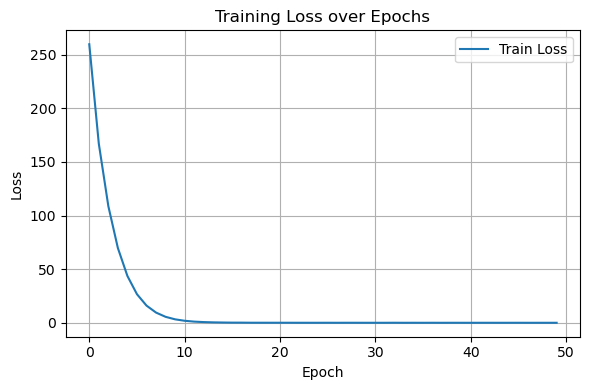

In [62]:
# Plot loss over epochs

loss = model.history.history.get('loss')
val_loss = model.history.history.get('val_loss')

plt.figure(figsize=(6,4))
plt.plot(loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Data processing for fine tuning

A language model such as Llama requires input data in textual format for fine-tuning. At this stage, we convert the sensor data into structured text so that it can be used for further training of the language model.




In [ ]:
best_model = load_model(LSTM_AE_path, custom_objects={'mse': mean_squared_error})

def get_anomaly_scores(X, best_model):
    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=1)  # Shape: (rows, 1, cols)
    reconstructed = best_model.predict(X)
    errors = np.mean((X.squeeze() - reconstructed.squeeze())**2, axis=1)  # MSE per sample
    return errors

train_scores = get_anomaly_scores(x_train, best_model)

def create_text_data(X, y, scores):
    data = []
    for i in range(len(X)):
        row = X.iloc[i]
        time = row['Time_Downsample']
        sensors = list(row.index)[4:]  # sensor columns start from column 5 (index 4)
        sensors_str = ', '.join([f"sensor{j+1} {sensors[j]}: {row[sensors[j]]:.2f}" for j in range(len(row)-1-4)])
        not_sensors = list(row.index)[:4]
        not_sensors_str = ', '.join([f"{not_sensors[j]}: {row[not_sensors[j]]:.2f}" for j in range(4)])
        
        score = scores[i]
        label = y[i]
        
        # prompt
        prompt = f"Analyze NASA C-MAPSS engine data after downsampling to minutes and minmax normalization. Elapsed time since flight start: {time} minutes. Not sensor measurements: {not_sensors_str}. Sensor measurements: {sensors_str}. LSTM anomaly score: {score:.4f}. Identify health state and possible faults in HPT or LPT."
        
        if label == 1:
            fault_text = "Normal operation, no faults."
        elif row['HPT_eff_mod'] != 0 and row['LPT_eff_mod'] == 0 and row['LPT_flow_mod'] == 0:
            fault_text = "Fault in HPT only."
        elif row['HPT_eff_mod'] != 0 and (row['LPT_eff_mod'] != 0 or row['LPT_flow_mod'] != 0):
            fault_text = "Faults in both HPT and LPT."
        else:
            fault_text = "Unknown state."

        # response with explanation
        response = f"Health state: {fault_text} Explanation: Anomaly score indicates degradation if above threshold."
        
        text = f"### Instruction: {prompt} ### Response: {response}"
        data.append({"text": text})
    return data

train_data = create_text_data(x_train, y_train, train_scores)

with open('train_dataset_text.jsonl', 'w') as f:
    for item in train_data:
        json.dump(item, f)
        f.write('\n')
print(type(train_data), len(train_data))

2749/2749 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step
<class 'list'> 87949
